In [1]:
import pandas as pd
from datetime import date
from dotenv import load_dotenv
import os
import nasdaqdatalink 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
# This loads the variables from .env
load_dotenv()  
# Get your apis or usernames
nsdk_api = os.getenv('api_key_nasdaq')

# Activate the account to download data
nasdaqdatalink.ApiConfig.api_key = nsdk_api

In [3]:
df = (
    nasdaqdatalink.get(dataset="FRED/UNRATENSA", 
                       start_date="2010-01-01", 
                       end_date="2019-12-31")
    .rename(columns={"Value": "unemp_rate"})
)
df

,unemp_rate
Date,
2010-01-01,10.6
2010-02-01,10.4
2010-03-01,10.2
2010-04-01,9.5
2010-05-01,9.3
...,...
2019-08-01,3.8
2019-09-01,3.3
2019-10-01,3.3


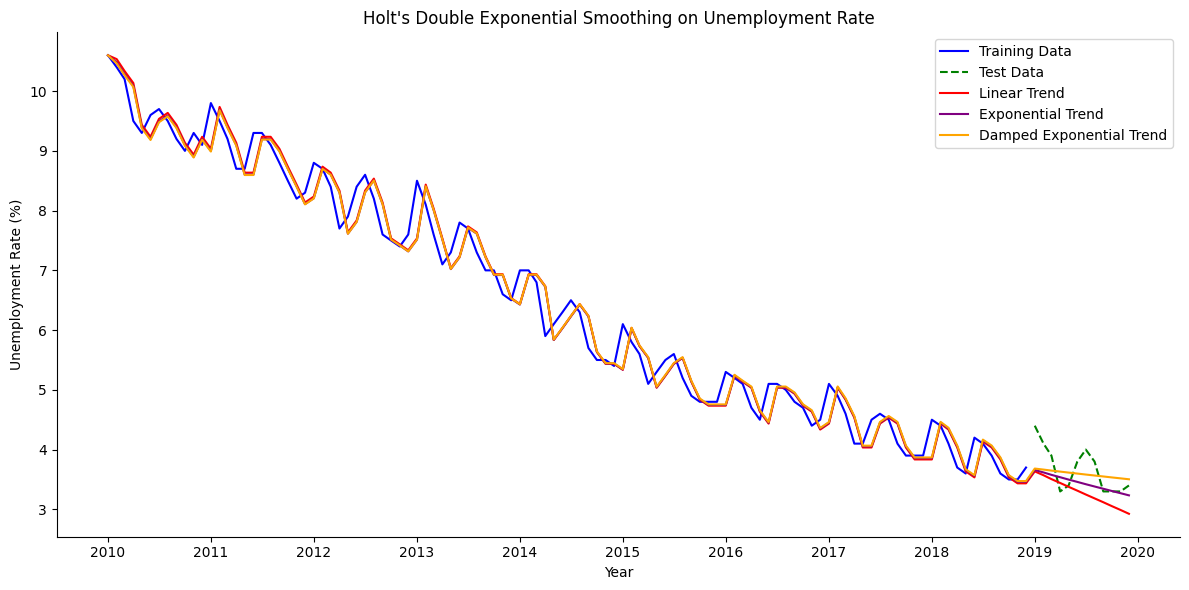

In [4]:


# Define the test set length, usually the last bits of the time series that you want to check if they are close or far from the actual dataset!
TEST_LENGTH = 12

# Ensure that the DataFrame index is set to monthly start frequency
df.index.freq = "MS"

# Split the data into training and test sets
df_train = df.iloc[:-TEST_LENGTH]
df_test = df.iloc[-TEST_LENGTH:]

# Fit Holt's model with a linear trend component
hs_linear = ExponentialSmoothing(df_train, trend="add").fit()
hs_linear_forecast = hs_linear.forecast(TEST_LENGTH)

# Fit Holt's model with an exponential (multiplicative) trend component
hs_exponential = ExponentialSmoothing(df_train, trend="mul").fit()
hs_exponential_forecast = hs_exponential.forecast(TEST_LENGTH)

# Fit Holt's model with an exponential trend and damping applied
hs_damped = ExponentialSmoothing(df_train, trend="mul", damped_trend=True).fit()
hs_damped_forecast = hs_damped.forecast(TEST_LENGTH)

# Create a DataFrame to hold the fitted values and forecasts using pandas.concat
hs_df = df.copy()
hs_df["Linear Trend"] = pd.concat([hs_linear.fittedvalues, hs_linear_forecast])
hs_df["Exponential Trend"] = pd.concat([hs_exponential.fittedvalues, hs_exponential_forecast])
hs_df["Damped Exponential Trend"] = pd.concat([hs_damped.fittedvalues, hs_damped_forecast])


# Plot the results with improvements
plt.figure(figsize=(12, 6))
plt.plot(df_train, label='Training Data', color='blue')
plt.plot(df_test, label='Test Data', color='green', linestyle='--')
plt.plot(hs_df['Linear Trend'], label='Linear Trend', color='red')
plt.plot(hs_df['Exponential Trend'], label='Exponential Trend', color='purple')
plt.plot(hs_df['Damped Exponential Trend'], label='Damped Exponential Trend', color='orange')

plt.title("Holt's Double Exponential Smoothing on Unemployment Rate")
plt.xlabel('Year')
plt.ylabel('Unemployment Rate (%)')
plt.legend(loc='upper right')
sns.despine()
plt.tight_layout()
plt.show()
